In [30]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics

In [7]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Dataset

# 2 Algorithm

#### Assume Sigma is known, and estimate $\pi$ by MLE


We want to compute the intractable GMM posterior:
$$
    p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma}) = \frac{p(\mathbf{X},\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{p(\mathbf{X}|\boldsymbol{\Sigma})}
$$

Introduce approximating distribution $q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})$ where we use KL divergence as a cost function 
$$
    \mathbb{KL}(q||p) = \sum_{\mathbf{z},\boldsymbol{\mu}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma})}
$$

Re-write as objective function
$$\begin{align}
    \mathcal{J}(q) &= \mathbb{KL}(q||p) = \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma})}d\boldsymbol{\mu}\\

        &=  \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu} - \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\mathbf{X},\boldsymbol{\Sigma})d\boldsymbol{\mu}\\

        &= \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu} -\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log \frac{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})}{p(\mathbf{X}|\boldsymbol{\Sigma})}d\boldsymbol{\mu}\\

        &= \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu} - \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\mu} + \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\mu}\\

        &= \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})d\boldsymbol{\mu} - \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})d\boldsymbol{\mu} + p(\mathbf{X}|\boldsymbol{\Sigma})\\

        &= \int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log \frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})}d\boldsymbol{\mu} + p(\mathbf{X}|\boldsymbol{\Sigma})\\

        &= \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) + p(\mathbf{X}|\boldsymbol{\Sigma})
\end{align}$$

Note 
$$
    \mathcal{J}(q) = \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) + \underbrace{p(\mathbf{X}|\boldsymbol{\Sigma})}_{\text{constant}}
$$

Hence our objective can simplify to
$$\begin{align}
    q* &\leftarrow \argmin_{q} \left[  \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big)  + \underbrace{p(\mathbf{X}|\boldsymbol{\Sigma})}_{\text{constant}} \right]\\
        &= \argmin_{q} \left[ \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) \right]
\end{align}$$

Define new objective function as $\mathcal{L}(q) = -\mathcal{J}(q) = -\mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big) - p(\mathbf{X}|\boldsymbol{\Sigma})$

We can show that $\mathcal{L}(q)$ is ELBO for data log likelihood :
$$\begin{align}
    \log p(\mathbf{X}|\boldsymbol{\Sigma}) = \log \int \sum_z p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})d\mu
\end{align}$$
The following always holds
$$\begin{align}
    \log p(\mathbf{X}) = \log \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu   
\end{align}$$    
Jensen's Inequality gives the following
$$\begin{align}
    &\log p(\mathbf{X}|\boldsymbol{\Sigma}) = \log \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu \geq \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \log \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu\\\\

    &\implies \log p(\mathbf{X}|\boldsymbol{\Sigma}) \geq \int \sum_z q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) \cdot \log \frac{p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} d\mu\\\\

    &\implies \log p(\mathbf{X}|\boldsymbol{\Sigma}) \geq -\mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{X}|\boldsymbol{\Sigma})\Big)\\\\

    &\implies \log p(\mathbf{X}|\boldsymbol{\Sigma}) \geq \mathcal{L}(q)
\end{align}$$
Therefore by maximizing $\mathcal{L}$, we bring $q$ closer to true posterior and maximize ELBO of marginal data log likelihood.

---

We have 
$$
    \mathcal{L}(q) = \mathbb{E}_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}[\log p(\mathbf{X},\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi}|\boldsymbol{\Sigma})] - \mathbb{E}_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})}[\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})]
$$

And want to compute 
$$
    \frac{d\mathcal{L}}{q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi})} = 0
$$

---

## Mean Field
Mean Field Independence Simplifying Assumption :
$$
    q(\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi}) = q(\boldsymbol{\pi})\prod_n^N \underbrace{q_n(z_n)}_{\text{Cat}} \prod_k^K \underbrace{q_k(\mu_k)}_{\text{Gaussian}}
$$

### Mean Field Update Steps 
$$\begin{align}
    \log q(\boldsymbol{\mu},\boldsymbol{\pi}) &= \mathbb{E}_{q(\mathbf{z})}[\log p(\mathbf{z},\boldsymbol{\mu},\mathbf{X}|\boldsymbol{\Sigma})] + \text{const}\\
    \log q(\mathbf{z}) &= \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\pi})}[\log p(\mathbf{z},\boldsymbol{\mu},\mathbf{X}|\boldsymbol{\Sigma})] + \text{const}\\
\end{align}$$

Assumptions 
1) Prior on $\boldsymbol{\pi}$ is Dirichlet
2) Prior on $\boldsymbol{\mu}$ is MVN
3) Prior on $\mathbf{z}$ is categorical
4) Sigma is known


### Updates for variational posterior of model parameters $q(\boldsymbol{\pi},\boldsymbol{\mu})$


$$\begin{align}
    \log q(\boldsymbol{\pi},\boldsymbol{\mu}) &= \mathbb{E}_{q(\mathbf{z})}\Big[\log p(\mathbf{X},\boldsymbol{\mu},\mathbf{z}|\boldsymbol{\Sigma})\Big] + \text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[\log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma})p(\boldsymbol{\mu})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})\Big] + \text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[ \log {p(\boldsymbol{\pi})} + \log p(\mathbf{z}|\boldsymbol{\pi}) +p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma}) \Big] + \log p(\boldsymbol{\mu}) + \text{const}\\ 

    &= \log p(\boldsymbol{\pi}) + \mathbb{E}_{q(\mathbf{z})}\Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \mathbb{E}_{q(z)}\Big[ \log p(\mathbf{X}|\boldsymbol{\mu},
    \mathbf{z},\boldsymbol{\Sigma}) \Big] + \log p(\boldsymbol{\mu}) + \text{const}\\
\end{align}$$

Can separate RHS into terms containing $\pi$ and $\mu$ for update steps $q(\pi)$ and $q(\mu)$  

Update Step for $q(\boldsymbol{\pi})$  

$$\begin{align}
    \log q(\boldsymbol{\pi}) &= \log p(\boldsymbol{\pi}) + \mathbb{E}_{q(\mathbf{z})}\Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \text{const}\\

    &= \log \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \mathbb{E}_{q(\mathbf{z})}\Big[ \sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big] + \text{const}\\

    &= \log \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \mathbb{E}_{q(z)} \Big[\sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big] + \text{const}\\

    &=  \underbrace{-\log B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \log \pi_k^{\alpha_0 - 1} + \mathbb{E}_{q(\mathbf{z})} \Big[ \sum_n^N \log \prod_k^K \pi_{k}^{z_{nk}} \Big] + \text{const}, \quad \text{where z$_{nk}$ is zero-hot}\\ 

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \mathbb{E}_{q(\mathbf{z})}\Big[ \sum_n^N \sum_k^K  z_{nk}\log \pi_{k} \Big] + \text{const}, \quad -\log B(\alpha_0) \text{ absorbed into const}\\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N  \mathbb{E}_{q(\mathbf{z})}\big[z_{nk}\big] \log \pi_{k} + \text{const}\\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N r_{nk} \cdot \log \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \sum_n^N r_{nk} \cdot \log \pi_{k} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \log \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \log \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\

\end{align}$$

Update step for $q(\boldsymbol{\mu})$  

$$\begin{align}
    \log q(\boldsymbol{\mu}) &= \mathbb{E}_{q(\mathbf{z})}\Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z}) \Big] +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[\sum_n^N \log \prod_k^K p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)^{z_{nk}} \Big] +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \mathbb{E}_{q(\mathbf{z})}\Big[\sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)^{z_{nk}} \Big] +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \sum_n^N \sum_k^K \mathbb{E}_{q(\mathbf{z})}\big[z_{nk}\big] \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) +  \log p(\boldsymbol{\mu}) +\text{const}\\

    &= \sum_k^K \sum_n^N  \Big[ r_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_k^K \log p(\mu_k) + \text{const}\\

    &= \sum_k^K \Big[ \log p(\mu_k) +  \sum_n^N r_{nk} \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \text{const} \\

    \implies & \log q(\boldsymbol{\mu}) = \sum_k^K \log q(\mu_k)\\
\end{align}$$
Hence,
$$
\begin{align}
    \log q(\boldsymbol{\mu}_k) &= \log p(\boldsymbol{\mu}_k) +  \sum_n^N r_{nk} \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) + \text{const}\\

    &= \log \mathcal{N}(\boldsymbol{\mu}_k|\mathbf{m}_{0,k}, \mathbf{V}_{0,k}) + \sum_n^N r_{nk} \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) + \text{const}\\

    &= \big( \underbrace{-\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\mathbf{V}_{0,k}^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})}_{\text{Terms dependent on $\mu_k$}} \big) + \sum_n^N r_{nk} \big(\underbrace{-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)}_{\text{Terms dependent on $\mu_k$}}\big) + \text{const}\\

    &=  -\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\mathbf{V}_{0,k}^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) - \frac{1}{2}\Big[\underbrace{\text{Tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{\bar{\mathbf{x}}_k})}_{\text{Constant w.r.t $\boldsymbol{\mu}_k$}} + N_k(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)\Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk},\quad \bar{\mathbf{x}}_k = \sum_n^N r_{nk}\cdot\mathbf{x}_n\\

    &= -\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\mathbf{V}_{0,k}^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) - \frac{N_k}{2}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k) + \text{const}, 
    \quad \text{Trace absorbed into const}\\\\

    &= -\frac{1}{2}\Big[
        \underbrace{ \boldsymbol{\mu}_k^T\mathbf{V}_{0,k}^{-1}\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k}}_{\text{Prior Component}} + 
        
        \underbrace{N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k - 2N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k}_{\text{Likelihood Component}} \Big] + \text{const}\\\\

    &= -\frac{1}{2} \Big[ 
        \big(\boldsymbol{\mu}_k^T\mathbf{V}_{0,k}^{-1}\boldsymbol{\mu}_k  + N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k) -
        \big(2\boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\mathbf{m}_{0,k} - 2N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k) + 
        \big(\mathbf{m}_{0,k}^T\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k)
    \Big] + \text{const}, \quad \text{Re-group terms}\\\\

    &= -\frac{1}{2} \Big[ 
            \boldsymbol{\mu}_k^T(\mathbf{V}_k^{-1} - N_k\boldsymbol{\Sigma}_k^{-1})\boldsymbol{\mu}_k \quad - \quad 
            
            2\boldsymbol{\mu}_k^T(\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}_n^T}) \quad + \quad 
            
            \mathbf{m}_{0,k}^T\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Big] + \text{const}\\\\

    &= -\frac{1}{2} \Big[
        \big(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b} \big)^T \mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) - \underbrace{\mathbf{b^TM^{-1}b}}_{\text{Independent of $\boldsymbol{\mu}_k$}}
    \Big] + \text{const}, \quad \text{Complete the multivariate square}\\
    
    &\begin{align*}
        \text{where},\qquad&\\
        &\mathbf{M} = (\mathbf{V}_k^{-1} - N_k\boldsymbol{\Sigma}_k^{-1})\\
        &\mathbf{b} = (\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}_n^T})\\
    \end{align*}

    &= -\frac{1}{2} \Big[
        \big(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b} \big)^T \mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
    \Big] + \text{const}, \quad \text{Absorb independent terms into constant}\\\\
    

    &\implies q(\mu_k) = \exp \Big( -\frac{1}{2} \big[
        \big(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b} \big)^T \mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
    \big] \Big) + \text{const}\\

\end{align}
$$

This is MVN form. Hence,

$$\begin{align}
    q(\mu_k) &=  \mathcal{N}\Big(\mu_k|\mathbf{m}_k,\mathbf{V}_k \Big)\\
        & N_k = \sum_n^N \gamma_{n,k}\\
        & \bar{\mathbf{x}}_k = \frac{1}{N_k}\sum_n^N \gamma_{n,k} \cdot \mathbf{x}_n\\
        & \mathbf{V}_k = \Big(\mathbf{V}_{0,k}^{-1} + N_k\Sigma_k^{-1}\Big)^{-1}\\
        & \mathbf{m}_k = \mathbf{V}_k \Big(\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + \Sigma_k^{-1}(N_k\bar{\mathbf{x}}_k) \Big)
\end{align}$$

### Updates for variational posterior of latent variable $q(\mathbf{z})$

$$\begin{align}
    \log q(\mathbf{z}) &= \mathbb{E}_{\boldsymbol{\mu},\boldsymbol{\pi}} \Big[ \log p(\mathbf{X},\boldsymbol{\mu},\boldsymbol{\pi},\mathbf{z}|\boldsymbol{\Sigma}) \Big] + \text{const}\\

    &= \mathbb{E}_{\boldsymbol{\mu},\boldsymbol{\pi}} \Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma}) p(\boldsymbol{\mu}) p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big] + \text{const}\\

    &= \mathbb{E}_{\boldsymbol{\mu},\boldsymbol{\pi}} \Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma})\Big] + \mathbb{E}_{\boldsymbol{\pi}} \Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \underbrace{\mathbb{E}_{\boldsymbol{\mu}} \Big[ \log p(\boldsymbol{\mu}) \Big] + \mathbb{E}_{\boldsymbol{\pi}} \Big[ \log p(\boldsymbol{\pi}) \Big]}_{\text{Independent of $\mathbf{z}$}} + \text{const}\\

    &=  \mathbb{E}_{\boldsymbol{\mu},\boldsymbol{\pi}} \Big[ \log p(\mathbf{X}|\boldsymbol{\mu},\mathbf{z},\boldsymbol{\Sigma}) \Big] + \mathbb{E}_{\boldsymbol{\pi}} \Big[ \log p(\mathbf{z}|\boldsymbol{\pi}) \Big] + \text{const}, \quad \text{Independent terms absorbed into const}\\\\


    &= \mathbb{E}_{\boldsymbol{\mu}} \Big[ \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k)^{z_{nk}} \Big] + \mathbb{E}_{\boldsymbol{\pi}} \Big[ \sum_n^N \sum_k^K \log p(z_n=k|\boldsymbol{\pi})^{z_{nk}} \Big] + \text{const}\\

    &= \sum_n^N \sum_k^K \mathbb{E}_{\boldsymbol{\mu}} \Big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_n^N \sum_k^K \mathbb{E}_{\boldsymbol{\pi}} \Big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \Big] + \text{const}\\

    &= \sum_n^N \left[ \sum_k^K \mathbb{E}_{\boldsymbol{\mu}} \Big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_k^K \mathbb{E}_{\boldsymbol{\pi}} \Big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \Big]\right] + \text{const}\\

    \implies & \log q(\mathbf{z}) = \prod_n^N q(z_n)
\end{align}$$
Hence
$$\begin{align}
    \log q(z_n) &= \sum_k^K \mathbb{E}_{\boldsymbol{\mu}} \Big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \sum_k^K \mathbb{E}_{\boldsymbol{\pi}} \Big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \Big] + \text{const}\\

    &= \sum_k^K \Big[ \mathbb{E}_{\boldsymbol{\mu}} \big[z_{nk} \cdot \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \big] + \mathbb{E}_{\boldsymbol{\pi}} \big[ z_{nk} \cdot \log \boldsymbol{\pi}_{k} \big] \Big] + \text{const} \\

    &= \sum_k^K  z_{nk} \cdot \Big[ \mathbb{E}_{\boldsymbol{\mu}}\big[ \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \big] + \mathbb{E}_{\boldsymbol{\pi}}\big[ \log \boldsymbol{\pi}_{k} \big]  \Big] + \text{const}\\
\end{align}$$

This gives 

$$\begin{align}
    \log q(z_n=k) &= \mathbb{E}_{\boldsymbol{\mu}}\Big[ \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_k) \Big] + \mathbb{E}_{\boldsymbol{\pi}}\Big[ \log \boldsymbol{\pi}_{k} \Big] + \text{const}\\\\

    &= \mathbb{E}_{\boldsymbol{\mu}}\Big[ \underbrace{-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)}_{\text{Terms dependent on $\boldsymbol{\mu}_k$}} \Big] + \mathbb{E}_{\boldsymbol{\pi}}\Big[ \log \boldsymbol{\pi}_{k} \Big] + \text{const}\\\\

    &= \mathbb{E}_{\boldsymbol{\mu}} \Big[\mathbf{x}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_k - 2\mathbf{x}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big] 
\end{align}$$

In [70]:
def update_μ(X, R, Σ, Λ_0, μ_0, K):
    N, D = X.shape

    S = np.zeros((K, D, D))  # Covariances of q(μ_k)
    m = np.zeros((K, D))     # Means of q(μ_k)

    nk = np.sum(R, axis=0)  # (K,)

    for k in range(K):
        Σ_inv = np.linalg.inv(Σ[k])
        
        if nk[k] == 0:
            continue  # Avoid division by zero

        x_bar_k = np.sum(R[:, k, None] * X, axis=0) / nk[k]  # (D,)

        Sk_inv = Λ_0 + nk[k] * Σ_inv
        Sk = np.linalg.inv(Sk_inv)

        mk = Sk @ (Λ_0 @ μ_0 + Σ_inv @ np.sum(R[:, k, None] * X, axis=0))

        S[k] = Sk
        m[k] = mk

    return S, m

In [65]:
def update_z(X,m,S,Σ,K):
    N,D = X.shape 

    R = np.zeros((N,K))

    for k in range(K):
        Σ_inv = np.linalg.inv(Σ[k])
        diff = X - m[k]

        term1 = np.trace(Σ_inv @ S[k])
        term2 = np.sum(diff @ Σ_inv * diff, axis=1)

        R[:,k] = -0.5 * (term1 + term2)

    log_norm = logsumexp(R, axis=1, keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik

In [25]:
def meanfield_vi(X,K,Σ,max_iters=100,tol=1e-4):
    N,D = X.shape

    R = rng.random((N,K))
    R /= R.sum(axis=1, keepdims=True)

    μ_0 = np.zeros((D)) 
    Λ_0 = np.eye(D)

    loglikes=[]
    
    S = np.zeros((K, D, D))  # Covariances of q(μ_k)
    m = np.zeros((K, D))     # Means of q(μ_k)

    for t in range(max_iters):
        S,m = update_μ(X,R,Σ,Λ_0,μ_0,K)

        R,loglike = update_z(X,m,S,Σ,K)

        loglikes.append(loglike)

        if (t > 1) and np.abs(loglikes[t] - loglikes[t-1] < tol) :
            break

    return R, S, m, loglikes
        


# 2.1 Evaluation

In [56]:
# component 1
Σ1 = np.array([[2,1.3],[1.3,4]])
μ1 = np.array([1,1])
X1 = np.random.multivariate_normal(μ1, Σ1, size=1000)
y1 = np.zeros((1000))

# component 2
Σ2 = np.array([[2,1.5],[1.5,2]])
μ2 = np.array([-2,6])
X2 = np.random.multivariate_normal(μ2, Σ2, size=900)
y2 = 1 * np.ones((900))

# component 3
Σ3 = np.array([[3,-1.2],[-1.2,1]])
μ3 = np.array([5,-2])
X3 = np.random.multivariate_normal(μ3, Σ3, size=1100)
y3 = 2 * np.ones((1100))

# component 4
Σ4 = np.array([[1,-0.75],[-0.75,2.4]])
μ4 = np.array([6,6])
X4 = np.random.multivariate_normal(μ4, Σ4, size=1000)
y4 = 3 * np.ones((1000))

# component 5
Σ5 = np.array([[3,2.3],[2.3,2.5]])
μ5 = np.array([8,3])
X5 = np.random.multivariate_normal(μ5, Σ5, size=850)
y5 = 2 * np.ones((850))

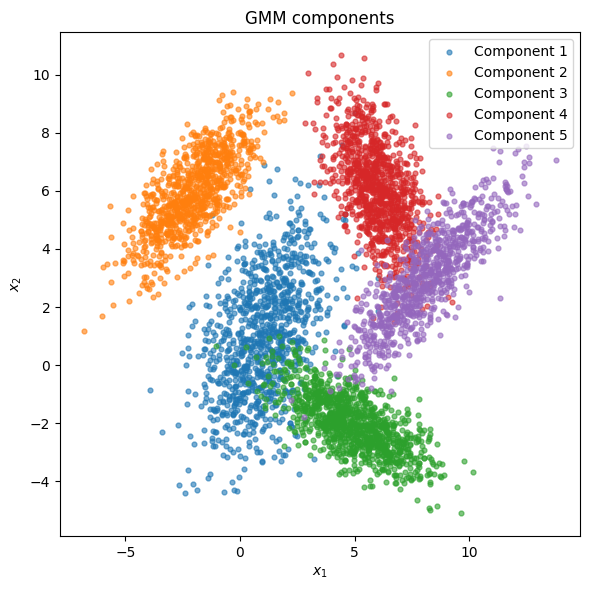

In [57]:
datasets = [
    (X1, "Component 1"),
    (X2, "Component 2"),
    (X3, "Component 3"),
    (X4, "Component 4"),
    (X5, "Component 5"),
]

# One distinct colour per component (tab10 has 10 nice qualitative colours)
colors = plt.cm.tab10(range(len(datasets)))

plt.figure(figsize=(6, 6))
for (Xi, label), c in zip(datasets, colors):
    plt.scatter(Xi[:, 0], Xi[:, 1], s=12, alpha=0.6, label=label, color=c)

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("GMM components")
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
Σ = np.array([Σ1,Σ2,Σ3,Σ4,Σ5])
μ = np.array([μ1,μ2,μ3,μ4,μ5])

X = np.vstack([X1, X2, X3, X4, X5])
y = np.concatenate([y1, y2, y3, y4, y5])

indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

In [66]:
R, S, m, loglikes = meanfield_vi(X,5,Σ,100)

In [67]:
zs = np.argmax(R, axis=1)

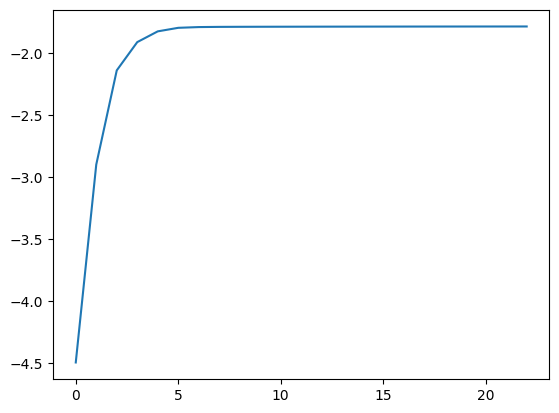

In [68]:
plt.plot(loglikes)

In [69]:
metrics.adjusted_rand_score(y, zs)

0.4904538671356836

# Extra 


#### Updating $q_{\boldsymbol{\mu}}(\boldsymbol{\mu})$
Assume that prior on $\boldsymbol{\mu}$ is Gaussian 
$$
    p(\boldsymbol{\mu}) = \prod_k^K p(\mu_k) = \prod_k^K \mathcal{N}(\mathbf{m}_{0,k}, \mathbf{V}_{0,k})
$$
Hence,
$$\begin{align}
    \log q_{\mu_k}(\mu_k) &= \mathbb{E}_{q(z)}[\log p(z,\mu,\mathbf{X})] + \underbrace{\text{const}}_{\text{normalization}}\\\\

        &= \mathbb{E}_{q(z)}[\log p(z,\mu,\mathbf{X})] + \text{const}\\\\

        &= \sum_n^N \mathbb{E}_{q(z_n)}[\log p(z_n,\mu_{z_n},\mathbf{x}_n)] + \text{const}\\

        &= \sum_n^N \sum_j^K q(z_n = j) \log \Big[ p(z_n=j,\mu_{j},\mathbf{x}_n) \Big] + \text{const}\\

        &= \sum_n^N \Big[ q(z_n = k) \log p(z_n=k,\mu_{k},\mathbf{x}_n) + \underbrace{\sum_{j\neq k}q(z_n = j)\log p(z_n=j,\mu_{j},\mathbf{x}_n)}_{\text{Independent of $\mu_k$}} \Big] + \text{const}\\

        &= \sum_n^N q(z_n = k) \cdot \log p(z_n=k,\mu_{k},\mathbf{x}_n) + \text{const}, \quad \text{absorb independent terms into constant}\\

        &= \sum_n^N q(z_n = k) \cdot \log p(\mathbf{x}_n|z_n = k,\mu_k)p(\mu_k)\underbrace{p(z_n=k)}_{\text{Independent of $\mu_k$}} + \text{const}\\

        &= \log p(\mu_k) + \sum_n^N q(z_n = k) \cdot \log  p(\mathbf{x}_n|z_n = k,\mu_k)+ \text{const}, \quad p(z_n=k) \text{ absorbed to constant}\\

        &= \log \mathcal{N}(\mu_k|\mathbf{m}_{0,k}, \mathbf{V}_{0,k}) + \sum_n^N \gamma_{n,k} \cdot \log \mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k) + \text{const}\\

        % &=  \underbrace{ -\frac{1}{2}(\mu_k - m_{0,k})^T\mathbf{V}_{0,k}^{-1}(\mu_k - m_{0,k})}_{\text{Terms depending on $\mu_k$ in $\mathcal{N}(\mu_k|\mathbf{m}_{0,k}, \mathbf{V}_{0,k})$}} + \sum_n^N \gamma_{n,k} \cdot \underbrace{-\frac{1}{2} (x_n - \mu_k)^T \Sigma_k^{-1}(x_n - \mu_k)}_{\text{Terms depending on $\mu_k$ in $\mathcal{N}(\mathbf{x}_n|\mu_k,\Sigma_k)$}} + \text{const}
\end{align}$$

Leverage conjugacy (Murphy 128) to derive $q_{\boldsymbol{\mu}}(\boldsymbol{\mu})$. With this we get valid normalized distribution and can ignore constant term.
$$\begin{align}
    q_{\mu_k}(\mu_k) &=  \mathcal{N}\Big(\mu_k|\mathbf{m}_k,\mathbf{V}_k \Big)\\
        & N_k = \sum_n^N \gamma_{n,k}\\
        & \bar{\mathbf{x}}_k = \frac{1}{N_k}\sum_n^N \gamma_{n,k} \cdot \mathbf{x}_n\\
        & \mathbf{V}_k = \Big(\mathbf{V}_{0,k}^{-1} + N_k\Sigma_k^{-1}\Big)^{-1}\\
        & \mathbf{m}_k = \mathbf{V}_k \Big(\mathbf{V}_{0,k}^{-1}\mathbf{m}_{0,k} + \Sigma_k^{-1}(N_k\bar{\mathbf{x}}_k) \Big)
\end{align}$$
